## Credit Scoring Models with Python

### 1. Background
Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. 

data source: https://www.kaggle.com/brycecf/give-me-some-credit-dataset?select=cs-training.csv


## Data Processing
### 2.1 Dataset Overview

In [2]:
#import library
import pandas as pd
import numpy as np
import seaborn as sns

#import data
train_data = pd.read_csv("cs-training.csv")
#remove the first column
train_data = train_data.iloc[:,1:]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [3]:
train_data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


The above result shows that there are many missing values in the MonthlyIncome Column(150000 - 120269 = 29731 missing). Ther are also missing values in the Number of Dependents column (missing 3924). 

### 2.2 Data Manipulation
#### 2.2.1 Missing Data

It is common to have missing values in the real dataset. Usually we can remove the missing values or use data imputation methods to fill the missing values.

In this dataset, since the proportion of missing values in the MonthlyIncome column is pretty large, we can use the method of Random Forest to fill the missing values.

In [4]:
from sklearn.ensemble import RandomForestRegressor
mdata = train_data.iloc[:,[5,0,1,2,3,4,6,7,8,9]]
train_known = mdata[mdata.MonthlyIncome.notnull()].to_numpy()
train_unknown = mdata[mdata.MonthlyIncome.isnull()].to_numpy()
train_X = train_known[:,1:]
train_Y = train_known[:,0]


rfr = RandomForestRegressor(random_state=0, n_estimators= 200, max_depth=3,n_jobs=-1) 
# n_jobs=-1: using all processors
# n_jobs=1：并行job个数。这个在ensemble算法中非常重要，尤其是bagging（而非boosting，
# 因为boosting的每次迭代之间有影响，所以很难进行并行化），
# 因为可以并行从而提高性能。1=不并行；n：n个并行；-1：CPU有多少core，就启动多少job
rfr.fit(train_X, train_Y)
predicted = rfr.predict(train_unknown[:,1:]).round(0)

#use the prediction result for missing data imputation
train_data.loc[train_data.MonthlyIncome.isnull(), 'MonthlyIncome'] = predicted
#remove other missing data and duplicate values
train_data = train_data.drop_duplicates()
train_data = train_data.dropna()

#### study notes for python random forest regressor

随机森林的随机性体现在： 

1.数据集的随机选取   

从原始的数据集中采取有放回的抽样（bagging），构造子数据集，子数据集的数据量是和原始数据集相同的。不同子数据集的元素可以重复，同一个子数据集中的元素也可以重复。

2.待选特征的随机选取  

与数据集的随机选取类似，随机森林中的子树的每一个分裂过程并未用到所有的待选特征，而是从所有的待选特征中随机选取一定的特征，之后再在随机选取的特征中选取最优的特征

为什么选择随机森林： 

1，随机森林既可以用于分类问题，也可以用于回归问题

2，过拟合是个关键的问题，可能会让模型的结果变得糟糕，但是对于随机森林来说，如果随机森林的树足够多，那么分类器就不会过拟合模型

3，随机森林分类器可以处理缺失值

4，随机森林分类器可以用分类值建模

随机森林构建过程：  

1，从原始训练集中使用Bootstraping方法随机有放回采样取出m个样本，共进行n_tree次采样。生成n_tree个训练集

2，对n_tree个训练集，我们分别训练n_tree个决策树模型

3，对于单个决策树模型，假设训练样本特征的个数为n，那么每次分裂时根据信息增益/信息增益比/基尼指数  选择最好的特征进行分裂

4，每棵树都已知这样分裂下去，知道该节点的所有训练样例都属于同一类。在决策树的分裂过程中不需要剪枝

5，将生成的多颗决策树组成随机森林。对于分类问题，按照多棵树分类器投票决定最终分类结果；对于回归问题，由多颗树预测值的均值决定最终预测结果

注意：OOB（out-of-bag ）：每棵决策树的生成都需要自助采样，这时就有1/3的数据未被选中，这部分数据就称为袋外数据。


进行预测可以有几种形式：

predict_proba(x)：给出带有概率值的结果。每个点在所有label的概率和为1.  

predict(x)：直接给出预测结果。内部还是调用的predict_proba()，根据概率的结果看哪个类型的预测值最高就是哪个类型。  

predict_log_proba(x)：和predict_proba基本上一样，只是把结果给做了log()处理。  

 


### 2.2.2 Outliers

After dealing with missing values, we need to check if the dataset also contains any outliers. Usually we define the outliers as the datapoints that are smaller than Q1 - 1.5 IQR or larger than Q3 + 1.5 IQR. 

iqr: inter quantile range = q3 - q1
lqr: low quantile range = median - q1
urq: upper quantile range = q3 - median

<AxesSubplot:>

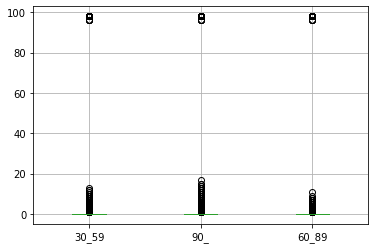

In [5]:
colNameDict=({
              'NumberOfTime30-59DaysPastDueNotWorse':'30_59',
              'NumberOfTimes90DaysLate':'90_',
              'NumberOfTime60-89DaysPastDueNotWorse':'60_89'})
train_data.rename(columns=colNameDict,inplace=True)
train_data.rename(columns=colNameDict,inplace=True)
train_box = train_data.iloc[:,[3,7,9]]
train_box.boxplot()

In [6]:
train_data = train_data[train_data['30_59']<90] # remove outliers
train_data = train_data[train_data['90_']<90] 
train_data = train_data[train_data['60_89']<90] 
train_data = train_data[train_data.age>0] # remove values where age <=0
train_data['SeriousDlqin2yrs'] = 1-train_data['SeriousDlqin2yrs'] # make good customers as 1, bad customers as 2

### 2.2.3 Exploratory Data Analysis



/Users/karen/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

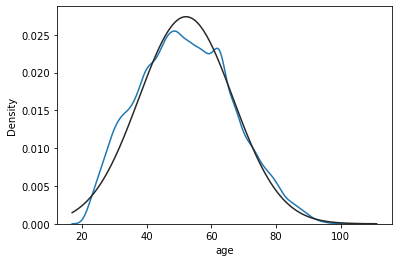

In [9]:
age = train_data['age']
from scipy.stats import *
sns.distplot(age,hist = False, fit = norm)

The above result show that the age are normally distributed in this dataset. The average age is around 50.

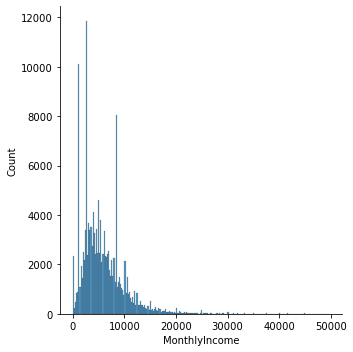

In [10]:
# MonthlyIncome Analysis
mi = train_data[train_data['MonthlyIncome']<50000]['MonthlyIncome']
sns.displot(mi)

The Monthly Income is left skewed based on the plot. The average monthly income is around 5000. The result shows that most people have a montly income below 10000, which also indicates that most people may have a high debt rate given their low income level. We can further investigate if the monthly income level is associated with the bad debt rate.

In [55]:
dat_df=train_data[['MonthlyIncome','SeriousDlqin2yrs']]
   #use cut function to tranform the continual variable to catogory variable
def dy_zh(col, cut_points, labels=None): 
    min_num = col.min() 
    max_num = col.max() 
    break_points = [min_num] + cut_points + [max_num]
    if not labels: 
        labels = range(len(cut_points)+1)
    else: 
        labels=[str(i+1)+":"+labels[i] for i in range(len(cut_points)+1)]         
    colBin = pd.cut(col,bins=break_points,
         labels=labels,include_lowest=True)    
    return colBin 
         
cut_points = [5000,10000,15000] 
labels=['below 5000', '5000-10000','1000-15000','above 15000'] 
dat_df['U_Bin'] = dy_zh(dat_df['MonthlyIncome'], cut_points, labels) 
dat_df.head()

<ipython-input-55-4df7d847091c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_df['U_Bin'] = dy_zh(dat_df['MonthlyIncome'], cut_points, labels)


,MonthlyIncome,SeriousDlqin2yrs,U_Bin
0,9120.0,1,2:5000-10000
1,2600.0,0,1:below 5000
2,3042.0,0,1:below 5000
3,3300.0,0,1:below 5000
4,63588.0,0,4:above 15000


In [56]:
#Compute the proportion of people who have past dues by region
import numpy as np
total_num=dat_df.shape[0]
per_table=pd.pivot_table(dat_df,index=['U_Bin'],
                         aggfunc={"MonthlyIncome":[len, lambda x:len(x)/total_num *100],
                                  "SeriousDlqin2yrs":[np.sum] },
                         values=['MonthlyIncome','SeriousDlqin2yrs']) 

per_table


MonthlyIncome          SeriousDlqin2yrs
                 <lambda_0>      len              sum
U_Bin                                                
1:below 5000      51.187446  74403.0             5842
2:5000-10000      36.210218  52633.0             3072
3:1000-15000       8.967761  13035.0              547
4:above 15000      3.634575   5283.0              245

In [57]:
#增加percent列，它的值来自另外两列数值之比
per_table['SeriousDlqin2yrs','percent']=per_table['SeriousDlqin2yrs','sum']/per_table['MonthlyIncome','len']*100
per_table


MonthlyIncome          SeriousDlqin2yrs          
                 <lambda_0>      len              sum   percent
U_Bin                                                          
1:below 5000      51.187446  74403.0             5842  7.851834
2:5000-10000      36.210218  52633.0             3072  5.836642
3:1000-15000       8.967761  13035.0              547  4.196394
4:above 15000      3.634575   5283.0              245  4.637517

In [52]:
#列名重命名
per_table=per_table.rename(columns={'<lambda_0>':'percent','len': 'number','sum':'number'})
#设置索引
per_table=per_table.reindex((per_table.columns[0],per_table.columns[3],
                              per_table.columns[2],per_table.columns[1]),axis=1)

per_table

DebtRatio MonthlyIncome              DebtRatio
                     number       percent   number       percent
U_Bin                                                           
1:below 5000   2.597485e+07     51.187446  74403.0  34911.029618
2:5000-10000   2.271661e+07     36.210218  52633.0  43160.390109
3:1000-15000   3.847113e+03      8.967761  13035.0     29.513719
4:above 15000  1.323084e+03      3.634575   5283.0     25.044180

### Divide data into training and testing sets

set the testing dataset = 30% of the training dataset

In [11]:
from sklearn.model_selection import train_test_split
y = train_data.iloc[:,0]
X = train_data.iloc[:,1:]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size  = 0.3, random_state = 0)
ntrain_data = pd.concat([train_y, train_X],axis=1)
ntest_data = pd.concat([test_y,test_X], axis =1)

### Binning 


分箱的作用： 当有多个离散变量时（分类变量）， binning可以避免维度灾难： 而分箱方法就是其中一种，它能够把非常多的类别按照一定的规则归并为少数的类别，从而突出了整体特征，

对于连续变量（也就是数值变量），我们需要认真思考一个问题：我们最后得到的是一个极大似然估计，也就是概率值。如果使用逻辑回归（LR），这个连续变量一个单位的变化，真的就呈线性地增加了这个概率了吗？我认为很多情况下，答案是否定的。当一个人的年龄超过一定的岁数，他再增长一岁给违约概率带来的变化其实不是特别的大。而且在不同年龄范围，每个人违约的概率收到年龄的影响也不尽相同，所以后面才会有一个叫做多元自适应回归样条的出现（其本质是分段线性回归）。不过对于这么多变量而言，做样条显然不划算，弄得模型非常复杂。比较好的选择就是，在数据准备的阶段对这些连续变量做分箱。

In [17]:
#define optimal binning function
from scipy import stats
def mono_bin(Y,X, n= 10):
    r = 0
    good = Y.sum()
    bad = Y.count() - good
    while np.abs(r)<1:
        d1 = pd.DataFrame({"X":X,"Y":Y,"Bucket":pd.qcut(X,n)})
        d2 = d1.groupby("Bucket",as_index=True)
        r,p = stats.spearmanr(d2.mean().X, d2.mean().Y)
        n = n-1
    d3 = pd.DataFrame(d2.X.min(), columns = ['min'])  
    d3['min'] = d2.min().X   
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().Y
    d3['total'] = d2.count().Y
    d3['rate'] = d2.mean().Y
    d3['woe'] = np.log(d3['rate']/(1-d3['rate']))/(good)/(bad)
    d3['goodattribute'] = d3['sum']/good
    d3['badattribute'] = (d3['total'] - d3['sum'])/bad
    iv = ((d3['goodattribute']-d3['badattribute'])*d3['woe']).sum()
    d4 = (d3.sort_values(by ='min')).reset_index(drop=True)
    woe = list(d4['woe'].round(3))
    cut = []
    cut.append(float('-inf'))
    for i in range(1,n+1):
        qua = X.quantile(i/(n+1))
        cut.append(round(qua,4))
    cut.append(float('inf'))
    return d4,iv,cut,woe

In [24]:
#use the above optimal binning fuction on RevolvingUtilizationOfUnsecuredLines、age、DebtRatio and MonthlyIncome

x1_d,x1_iv, x1_cut,x1_woe = mono_bin(train_y,train_X.RevolvingUtilizationOfUnsecuredLines)
x2_d,x2_iv, x2_cut,x2_woe = mono_bin(train_y,train_X.age)
x4_d,x4_iv, x4_cut,x4_woe = mono_bin(train_y,train_X.DebtRatio)
x5_d,x5_iv, x5_cut,x5_woe = mono_bin(train_y,train_X.MonthlyIncome)

In [28]:
def woe_value(d1):
    d2 = d1.groupby("Bucket",as_index=True)
    good = train_y.sum()
    bad = train_y.count() - good
    d3 = pd.DataFrame(d2.X.min(), columns = ['min'])  
    d3['min'] = d2.min().X   
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().Y
    d3['total'] = d2.count().Y
    d3['rate'] = d2.mean().Y
    d3['woe'] = np.log((d3['rate']/good)/(1-d3['rate'])/(bad))
    d3['goodattribute'] = d3['sum']/good
    d3['badattribute'] = (d3['total'] - d3['sum'])/bad
    iv = ((d3['goodattribute']-d3['badattribute'])*d3['woe']).sum()
    d4 = (d3.sort_values(by ='min')).reset_index(drop=True)
    woe = list(d4['woe'].round(3))
    return d4,iv,woe
    

### correlation analysis

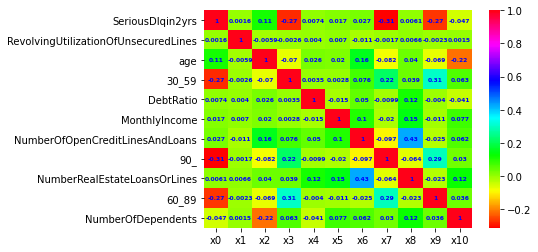

In [22]:
import matplotlib.pyplot as plt
corr = train_data.corr()
xticks = ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']
yticks = list(train_data.columns)
fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.heatmap(corr, annot = True, cmap = 'hsv', ax=ax1, annot_kws={'size':6, 'color':'blue', 'weight':'bold'})
ax1.set_xticklabels(xticks, rotation =0, fontsize = 10)
ax1.set_yticklabels(yticks, rotation =0, fontsize = 10)
plt.show()

The above heatmap shows the variables have small correlation coefficients with other variables.

### Calculate Information Value

In [ ]:
informationvalue = []
informationvalue.append(x1_iv)
informationvalue.append(x2_iv)
informationvalue.append(x3_iv)
informationvalue.append(x4_iv)
informationvalue.append(x5_iv)
informationvalue.append(x6_iv)
informationvalue.append(x7_iv)
informationvalue.append(x8_iv)
informationvalue.append(x9_iv)
informationvalue.append(x10_iv)
information_value
